In [1]:
#Data Ingestion 
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("IBM_COS_Read").getOrCreate()

# Set IBM COS Configuration
spark.conf.set("fs.stocator.scheme.list", "cos")
spark.conf.set("fs.cos.impl", "com.ibm.stocator.fs.ObjectStoreFileSystem")

# Use the provided HMAC credentials
spark.conf.set("fs.cos.mycos.access.key", "cd5b03b72dab47e085e2189585b60956")
spark.conf.set("fs.cos.mycos.secret.key", "f869b1fdfd8d5612ba28530f9aeaf76533d34f6da5e5bb7d")

# Set the correct COS endpoint
spark.conf.set("fs.cos.mycos.endpoint", "https://s3.us-south.cloud-object-storage.appdomain.cloud")

# Use the correct bucket and service alias format
cos_url = "cos://ibmbucket0987.mycos/SupermarketSales.csv"  

# Read the CSV file
df = spark.read.csv(cos_url, header=True, inferSchema=True)

# Display the first 5 rows
df.show(5)


+-----------+------+---------+-------------+------+--------------------+----------+--------+-------+--------+---------+-------------------+-----------+------+-----------------------+------------+------+
| Invoice ID|Branch|     City|Customer type|Gender|        Product line|Unit price|Quantity| Tax 5%|   Total|     Date|               Time|    Payment|  cogs|gross margin percentage|gross income|Rating|
+-----------+------+---------+-------------+------+--------------------+----------+--------+-------+--------+---------+-------------------+-----------+------+-----------------------+------------+------+
|750-67-8428|     A|   Yangon|       Member|Female|   Health and beauty|     74.69|       7|26.1415|548.9715| 1/5/2019|2025-02-17 13:08:00|    Ewallet|522.83|            4.761904762|     26.1415|   9.1|
|226-31-3081|     C|Naypyitaw|       Normal|Female|Electronic access...|     15.28|       5|   3.82|   80.22| 3/8/2019|2025-02-17 10:29:00|       Cash|  76.4|            4.761904762|      

In [2]:
#Data cleaning and preprocessing
from pyspark.sql.functions import col

df.select([col(c).isNull().alias(c) for c in df.columns]).show()


+----------+------+-----+-------------+------+------------+----------+--------+------+-----+-----+-----+-------+-----+-----------------------+------------+------+
|Invoice ID|Branch| City|Customer type|Gender|Product line|Unit price|Quantity|Tax 5%|Total| Date| Time|Payment| cogs|gross margin percentage|gross income|Rating|
+----------+------+-----+-------------+------+------------+----------+--------+------+-----+-----+-----+-------+-----+-----------------------+------------+------+
|     false| false|false|        false| false|       false|     false|   false| false|false|false|false|  false|false|                  false|       false| false|
|     false| false|false|        false| false|       false|     false|   false| false|false|false|false|  false|false|                  false|       false| false|
|     false| false|false|        false| false|       false|     false|   false| false|false|false|false|  false|false|                  false|       false| false|
|     false| false|fal

In [3]:
df = df.na.drop()


In [4]:
df = df.fillna({"Rating": df.selectExpr("avg(Rating)").collect()[0][0]})  # Fill missing ratings with avg


In [5]:
#Basic Data Exploration
df.count()


1000

In [6]:
from pyspark.sql.functions import col

df.select([col(c).isNull().alias(c) for c in df.columns]).show()


+----------+------+-----+-------------+------+------------+----------+--------+------+-----+-----+-----+-------+-----+-----------------------+------------+------+
|Invoice ID|Branch| City|Customer type|Gender|Product line|Unit price|Quantity|Tax 5%|Total| Date| Time|Payment| cogs|gross margin percentage|gross income|Rating|
+----------+------+-----+-------------+------+------------+----------+--------+------+-----+-----+-----+-------+-----+-----------------------+------------+------+
|     false| false|false|        false| false|       false|     false|   false| false|false|false|false|  false|false|                  false|       false| false|
|     false| false|false|        false| false|       false|     false|   false| false|false|false|false|  false|false|                  false|       false| false|
|     false| false|false|        false| false|       false|     false|   false| false|false|false|false|  false|false|                  false|       false| false|
|     false| false|fal

In [7]:
#Summary statistics
df.describe().show()


+-------+-----------+------+--------+-------------+------+--------------------+------------------+------------------+------------------+------------------+--------+-------+------------------+-----------------------+------------------+------------------+
|summary| Invoice ID|Branch|    City|Customer type|Gender|        Product line|        Unit price|          Quantity|            Tax 5%|             Total|    Date|Payment|              cogs|gross margin percentage|      gross income|            Rating|
+-------+-----------+------+--------+-------------+------+--------------------+------------------+------------------+------------------+------------------+--------+-------+------------------+-----------------------+------------------+------------------+
|  count|       1000|  1000|    1000|         1000|  1000|                1000|              1000|              1000|              1000|              1000|    1000|   1000|              1000|                   1000|              1000|    

In [8]:
#Total Sales per City
from pyspark.sql.functions import sum

df.groupBy("City").agg(sum("Total").alias("Total Sales")).show()


+---------+------------------+
|     City|       Total Sales|
+---------+------------------+
|Naypyitaw|110568.70649999994|
| Mandalay|106197.67199999996|
|   Yangon| 106200.3705000001|
+---------+------------------+



In [9]:
#Most Popular Product Line
df.groupBy("Product line").count().orderBy("count", ascending=False).show()


+--------------------+-----+
|        Product line|count|
+--------------------+-----+
| Fashion accessories|  178|
|  Food and beverages|  174|
|Electronic access...|  170|
|   Sports and travel|  166|
|  Home and lifestyle|  160|
|   Health and beauty|  152|
+--------------------+-----+



In [10]:
#Average Rating by Payment Method
from pyspark.sql.functions import avg

df.groupBy("Payment").agg(avg("Rating").alias("Avg Rating")).show()


+-----------+-----------------+
|    Payment|       Avg Rating|
+-----------+-----------------+
|    Ewallet|6.947826086956522|
|       Cash|6.970058139534882|
|Credit card|7.003215434083603|
+-----------+-----------------+



In [12]:
#Customer Segmentation (Using K-Means Clustering)
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["Unit price", "Quantity", "Total"], outputCol="features")
df_kmeans = assembler.transform(df)

kmeans = KMeans(k=3, seed=1)  # 3 clusters
model = kmeans.fit(df_kmeans)
predictions = model.transform(df_kmeans)
predictions.select("City", "Product line", "Total", "prediction").show()


+---------+--------------------+--------+----------+
|     City|        Product line|   Total|prediction|
+---------+--------------------+--------+----------+
|   Yangon|   Health and beauty|548.9715|         1|
|Naypyitaw|Electronic access...|   80.22|         0|
|   Yangon|  Home and lifestyle|340.5255|         1|
|   Yangon|   Health and beauty| 489.048|         1|
|   Yangon|   Sports and travel|634.3785|         2|
|Naypyitaw|Electronic access...|627.6165|         2|
|   Yangon|Electronic access...| 433.692|         1|
|Naypyitaw|  Home and lifestyle|  772.38|         2|
|   Yangon|   Health and beauty|  76.146|         0|
| Mandalay|  Food and beverages| 172.746|         0|
| Mandalay| Fashion accessories|  60.816|         0|
| Mandalay|Electronic access...| 107.142|         0|
|   Yangon|Electronic access...|246.4875|         0|
|   Yangon|  Food and beverages| 453.495|         1|
|   Yangon|   Health and beauty|  749.49|         2|
| Mandalay|   Sports and travel| 590.436|     

In [13]:
#Time Series Analysis (Sales Over Time)
from pyspark.sql.window import Window
from pyspark.sql.functions import avg

windowSpec = Window.orderBy("Date").rowsBetween(-3, 3)
df = df.withColumn("Moving_Avg_Sales", avg("Total").over(windowSpec))
df.select("Date", "Total", "Moving_Avg_Sales").show()


+---------+--------+------------------+
|     Date|   Total|  Moving_Avg_Sales|
+---------+--------+------------------+
| 1/1/2019| 457.443|429.04049999999995|
| 1/1/2019| 399.756|369.78479999999996|
| 1/1/2019| 470.673|330.15849999999995|
| 1/1/2019|  388.29|           371.742|
| 1/1/2019| 132.762| 322.6170000000001|
| 1/1/2019| 132.027|376.83899999999994|
| 1/1/2019| 621.243|           335.898|
| 1/1/2019| 113.568|           305.772|
| 1/1/2019|  779.31| 413.7509999999999|
| 1/1/2019| 184.086|405.76800000000003|
| 1/1/2019| 177.408|           417.555|
| 1/1/2019| 888.615|424.40999999999997|
|1/10/2019|  76.146|383.62199999999996|
|1/10/2019| 703.752| 413.4164999999999|
|1/10/2019| 161.553|471.92549999999994|
|1/10/2019| 493.794|432.27750000000003|
|1/10/2019|392.6475|429.66749999999996|
|1/10/2019| 586.971|397.29300000000006|
|1/10/2019| 611.079| 400.3620000000001|
|1/10/2019|  57.876|343.27349999999996|
+---------+--------+------------------+
only showing top 20 rows



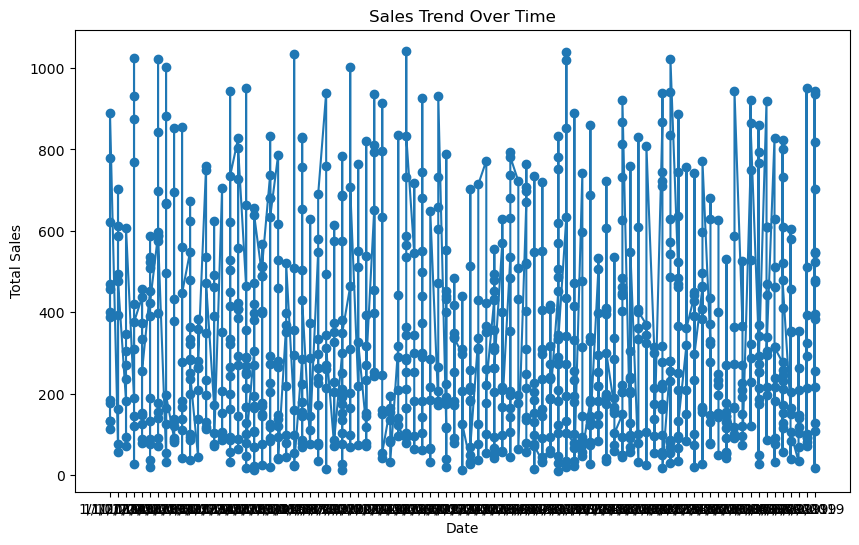

In [14]:
 #Integrate with Visualization Tools
import matplotlib.pyplot as plt
import pandas as pd

pdf = df.toPandas()
plt.figure(figsize=(10, 6))
plt.plot(pdf["Date"], pdf["Total"], marker="o", linestyle="-")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Sales Trend Over Time")
plt.show()
